# Taxi Prices Dataset

## Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt


df = pd.read_csv('../data/raw/taxi_trip_pricing.csv')

## Exploration

In [2]:
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


In [4]:
df.describe()

,Trip_Distance_km,Passenger_Count,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,951.000000
mean,27.070547,2.476842,3.502989,1.233316,0.292916,62.118116,56.874773
std,19.905300,1.102249,0.870162,0.429816,0.115592,32.154406,40.469791
min,1.230000,1.000000,2.010000,0.500000,0.100000,5.010000,6.126900
25%,12.632500,1.250000,2.730000,0.860000,0.190000,35.882500,33.742650
50%,25.830000,2.000000,3.520000,1.220000,0.290000,61.860000,50.074500
75%,38.405000,3.000000,4.260000,1.610000,0.390000,89.055000,69.099350
max,146.067047,4.000000,5.000000,2.000000,0.500000,119.840000,332.043689


In [5]:
df.isnull().sum()

Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

In [16]:
df_filt = df.copy()

filas_trip_price_nan = df_filt[df_filt['Trip_Price'].isna()]

print(filas_trip_price_nan.head(5))

    Trip_Distance_km Time_of_Day Day_of_Week  Passenger_Count  \
1              47.59   Afternoon     Weekday              1.0   
8              30.45     Morning     Weekday              3.0   
11             48.53       Night     Weekday              3.0   
32              4.19     Morning     Weekday              1.0   
94             38.78     Morning     Weekday              3.0   

   Traffic_Conditions Weather  Base_Fare  Per_Km_Rate  Per_Minute_Rate  \
1                High   Clear        NaN         0.62             0.43   
8                High   Clear       2.77         1.78             0.34   
11                Low   Clear       4.78          NaN             0.50   
32                Low   Clear       4.07         1.89             0.19   
94             Medium   Clear       3.08         1.62             0.15   

    Trip_Duration_Minutes  Trip_Price  
1                   40.57         NaN  
8                  110.33         NaN  
11                  79.94         NaN  
32  

I initially thought that the 50 missing values per feature were caused by the `Trip_Price` variable being NaN. I was planning to remove those rows, but now I see that it's better to impute the missing values instead.

In [10]:
# Print unique values of categorical data
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

for col in cat_cols:
    print(f"\nColumn: {col}")
    print(df[col].unique())


Column: Time_of_Day
['Morning' 'Afternoon' 'Evening' 'Night' nan]

Column: Day_of_Week
['Weekday' 'Weekend' nan]

Column: Traffic_Conditions
['Low' 'High' 'Medium' nan]

Column: Weather
['Clear' nan 'Rain' 'Snow']


Here we can see:

- 7 numerical features:
    - `Trip_Distance_km`: Distance of the trip, where the mean is 27km.
    - `Passenger_Count`: The passengers of the trip. Min. 1 - Max. 4
    - `Base_Fare`: The initial charge applied to every trip.
    - `Per_km_Rate`: The rate applied per kilometer.
    - `Per_Minute_Rate`: The rate applied per minute of the trip.
    - `Trip_Duration_Minutes`: Total trip duration in minutes.
    - `Trip_Price`: Target feature. With a mean of 56 and a deviation of 40.

- 4 categorical features:
    - `Time_of_Day`: 
    - `Day_of_Week`:
    - `Traffic_Conditions`:
    - `Weather`:

There's 50 values of each that have missing values. I decided to impute them with median values for the numerical features, and the most frequent to the categorial ones.

## Preprocessing

In [ ]:
df = df.dropna(subset=["Trip_Price"])

X = df.drop(columns=["Trip_Price"])
y = df["Trip_Price"]

num_cols = X.select_dtypes(include=["float64", "int64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"(X) Trainning Shape: {X_train.shape}")
print(f"(X) Test Shape: {X_test.shape}")

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols)
])

(X) Trainning Shape: (760, 10)
(X) Test Shape: (191, 10)
(Y) Trainning Shape: (760, 10)
(Y) Test Shape: (191, 10)


In [ ]:
# Only to visualize preprocessed data

X_preprocessed = preprocessor.fit_transform(X_train)

encoded_cat_cols = preprocessor.named_transformers_["cat"]["encoder"].get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, encoded_cat_cols])

X_processed_df = pd.DataFrame(
    X_preprocessed.toarray() if hasattr(X_preprocessed, "toarray") else X_preprocessed,
    columns=all_features
)

X_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Trip_Distance_km           760 non-null    float64
 1   Passenger_Count            760 non-null    float64
 2   Base_Fare                  760 non-null    float64
 3   Per_Km_Rate                760 non-null    float64
 4   Per_Minute_Rate            760 non-null    float64
 5   Trip_Duration_Minutes      760 non-null    float64
 6   Time_of_Day_Afternoon      760 non-null    float64
 7   Time_of_Day_Evening        760 non-null    float64
 8   Time_of_Day_Morning        760 non-null    float64
 9   Time_of_Day_Night          760 non-null    float64
 10  Day_of_Week_Weekday        760 non-null    float64
 11  Day_of_Week_Weekend        760 non-null    float64
 12  Traffic_Conditions_High    760 non-null    float64
 13  Traffic_Conditions_Low     760 non-null    float64

## Training

### LinearRegression

After preprocessing Shapes
(X) Trainning Shape: (760, 10)
(X) Test Shape: (191, 10)

=== Regresión Lineal Múltiple ===
MAE Train: 9.3103
RMSE Train: 14.3960
R² Train: 0.8577

---
MAE Test: 9.9304
RMSE Test: 17.0289
R² Test: 0.8759


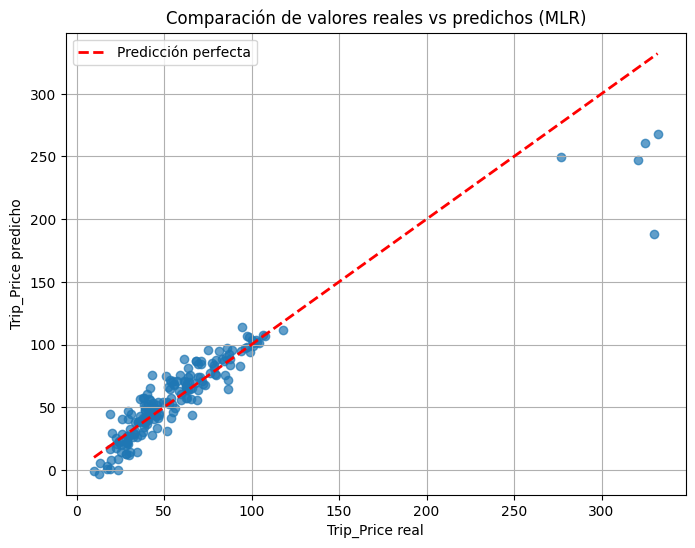

In [ ]:
lr = LinearRegression()

mlr_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", lr)
])

# Entrenamiento
mlr_model.fit(X_train, y_train)

# Predicciones
y_train_pred_lr = mlr_model.predict(X_train)
y_pred_lr = mlr_model.predict(X_test)

# Métricas
mae_train_lr = mean_absolute_error(y_train, y_train_pred_lr)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
r2_train_lr = r2_score(y_train, y_train_pred_lr)

mae_test_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_test_lr = r2_score(y_test, y_pred_lr)

print("\n=== Regresión Lineal Múltiple ===")
print(f"MAE Train: {mae_train_lr:.4f}")
print(f"RMSE Train: {rmse_train_lr:.4f}")
print(f"R² Train: {r2_train_lr:.4f}")
print("\n---")
print(f"MAE Test: {mae_test_lr:.4f}")
print(f"RMSE Test: {rmse_test_lr:.4f}")
print(f"R² Test: {r2_test_lr:.4f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Predicción perfecta')
plt.xlabel("Trip_Price real")
plt.ylabel("Trip_Price predicho")
plt.title("Comparación de valores reales vs predichos (MLR)")
plt.legend()
plt.grid(True)
plt.show()

### XGBoost

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Mejores parámetros encontrados:
{'regressor__colsample_bytree': 0.8, 'regressor__learning_rate': 0.05, 'regressor__max_depth': 3, 'regressor__n_estimators': 300, 'regressor__subsample': 0.8}

=== Métricas de Entrenamiento ===
MAE Train: 2.6780
RMSE Train: 4.5341
R² Train: 0.9859

=== Métricas de Test ===
MAE Test: 5.5099
RMSE Test: 13.5535
R² Test: 0.9214


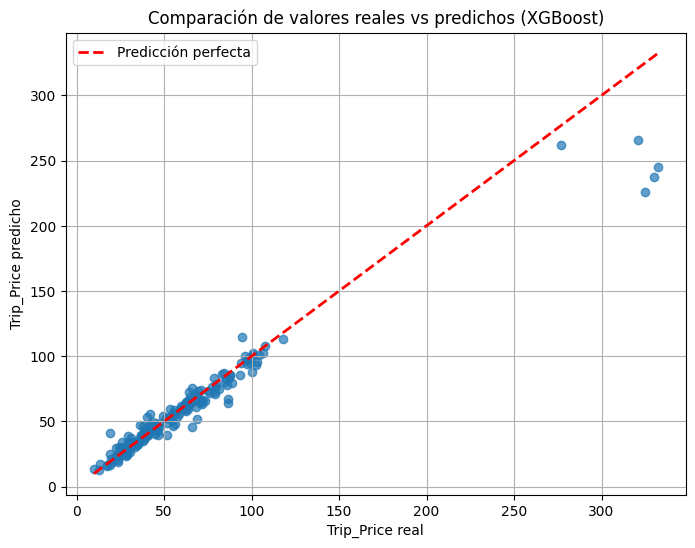

In [ ]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb)
])

param_grid = {
    "regressor__n_estimators": [100, 300],
    "regressor__max_depth": [3, 5, 7],
    "regressor__learning_rate": [0.05, 0.1, 0.2],
    "regressor__subsample": [0.8, 1.0],
    "regressor__colsample_bytree": [0.8, 1.0]
}

grid_search = GridSearchCV(
    model,
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="neg_mean_absolute_error"
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_train_pred = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print("\nMejores parámetros encontrados:")
print(grid_search.best_params_)

print("\n=== Métricas de Entrenamiento ===")
print(f"MAE Train: {mae_train:.4f}")
print(f"RMSE Train: {rmse_train:.4f}")
print(f"R² Train: {r2_train:.4f}")

print("\n=== Métricas de Test ===")
print(f"MAE Test: {mae_test:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")
print(f"R² Test: {r2_test:.4f}")


plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Predicción perfecta')
plt.xlabel("Trip_Price real")
plt.ylabel("Trip_Price predicho")
plt.title("Comparación de valores reales vs predichos (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

### Multilayer Neuronal Network (PyTorch)

Epoch 0/100, Loss: 3956.6323
Epoch 10/100, Loss: 360.0802
Epoch 20/100, Loss: 336.9536
Epoch 30/100, Loss: 309.2765
Epoch 40/100, Loss: 272.1717
Epoch 50/100, Loss: 279.4552
Epoch 60/100, Loss: 231.1677
Epoch 70/100, Loss: 210.9602
Epoch 80/100, Loss: 196.2886
Epoch 90/100, Loss: 189.3689

=== Red Neuronal (PyTorch) ===
MAE Train: 8.6837
RMSE Train: 12.1225
R² Train: 0.8991

---
MAE Test: 9.5932
RMSE Test: 15.0075
R² Test: 0.9036


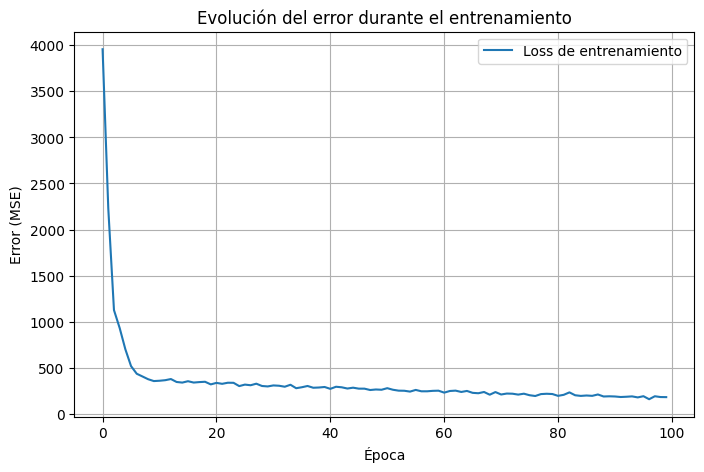

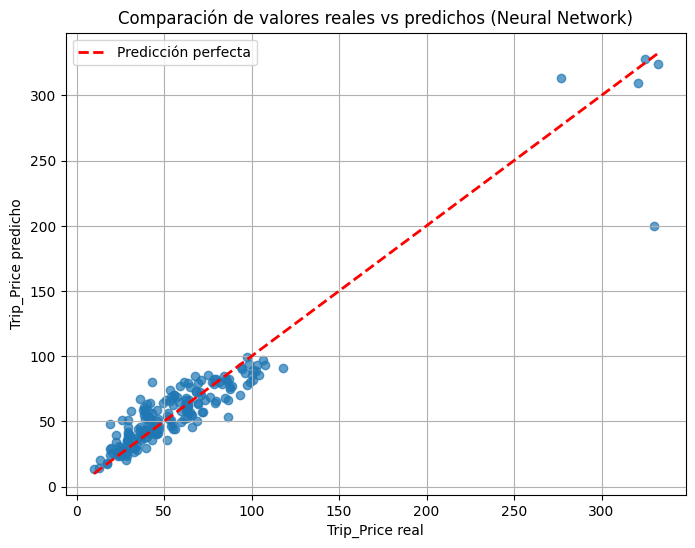

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

X_processed = preprocessor.fit_transform(X)

# Convertir a arrays NumPy
X_processed = np.array(X_processed.todense() if hasattr(X_processed, "todense") else X_processed)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class TaxiNN(nn.Module):
    def __init__(self, input_dim):
        super(TaxiNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


input_dim = X_train.shape[1]
model = TaxiNN(input_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")



model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).numpy()
    y_pred = model(X_test_tensor).numpy()

mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print("\n=== Red Neuronal (PyTorch) ===")
print(f"MAE Train: {mae_train:.4f}")
print(f"RMSE Train: {rmse_train:.4f}")
print(f"R² Train: {r2_train:.4f}")
print("\n---")
print(f"MAE Test: {mae_test:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")
print(f"R² Test: {r2_test:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Loss de entrenamiento")
plt.xlabel("Época")
plt.ylabel("Error (MSE)")
plt.title("Evolución del error durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--', lw=2, label='Predicción perfecta')
plt.xlabel("Trip_Price real")
plt.ylabel("Trip_Price predicho")
plt.title("Comparación de valores reales vs predichos (Neural Network)")
plt.legend()
plt.grid(True)
plt.show()
